In [3]:
import torch
import torchvision
from torchvision import transforms, models
import pathlib
import importlib
from GeneratorEncoderTriplets.GAN import model
from matplotlib import pyplot as plt

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# checkpoint_dir = pathlib.Path('./GeneratorEncoderTriplets/weights/')
checkpoint_dir = pathlib.Path('./hackaton/TripletsEncoderGAN-experiments/checkpoints4')
test_images_dir = pathlib.Path('./hackaton/TripletsEncoderGAN-experiments/dataset/val')

In [10]:
generator = model.Generator(256, 64, w_hpf=0)
generator.load_state_dict(
    torch.load(
        pathlib.Path(checkpoint_dir / '040000_nets.ckpt'), map_location=DEVICE
        )['generator']
    )
# style_encoder = model.StyleEncoder(256, 64, 3)
# # style_encoder.load_state_dict(
# #     torch.load(
# #         pathlib.Path(checkpoint_dir / 'triplets_encoder.pth'), map_location=DEVICE
# #         )
# #     )
# style_encoder.load_state_dict(
#     torch.load(
#         pathlib.Path(checkpoint_dir / '037500_nets.ckpt'), map_location=DEVICE
#         )['style_encoder']
#     )
style_encoder = models.resnet50()
fc_in_features = style_encoder.fc.in_features
style_encoder.fc = torch.nn.Linear(in_features=fc_in_features, out_features=64)
style_encoder.load_state_dict(
    torch.load(
        pathlib.Path('./hackaton/TripletsEncoderGAN-experiments/checkpoints/triplets_encoder_resnet50.pth'), map_location=DEVICE
        )
    )
generator.to(DEVICE)
style_encoder.to(DEVICE);

In [11]:
transform = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5]),
])
source = torchvision.datasets.ImageFolder(test_images_dir / 'source', transform)
reference = torchvision.datasets.ImageFolder(test_images_dir / 'reference', transform)

In [12]:
source.classes, source[0][0].shape, reference.classes, reference[0][0].shape

(['normal'],
 torch.Size([3, 256, 256]),
 ['cancer', 'covid'],
 torch.Size([3, 256, 256]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


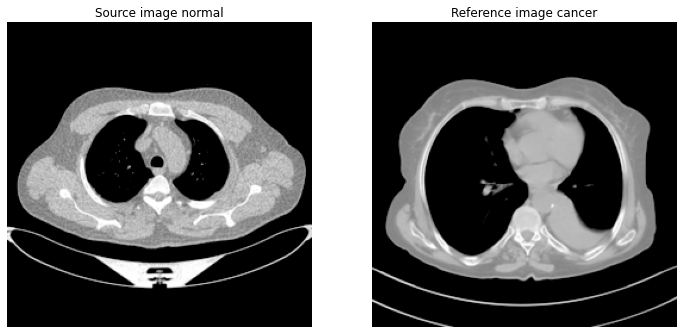

In [30]:
x, y = source[12]
x_ref, y_ref = reference[14]

plt.figure(figsize=(12, 9))
plt.subplot(1, 2, 1)
plt.title(f'Source image {source.classes[y]}')
plt.imshow(x.permute(1, 2, 0))
plt.axis(False)

plt.subplot(1, 2, 2)
plt.title(f'Reference image {reference.classes[y_ref]}')
plt.imshow(x_ref.permute(1, 2, 0))
plt.axis(False);

In [31]:
x, y = x.unsqueeze(dim=0).to(DEVICE), torch.LongTensor([y + 2])
x_ref, y_ref = x_ref.unsqueeze(dim=0).to(DEVICE), torch.LongTensor([y_ref])

In [38]:
with torch.inference_mode():
    style_encoder.eval()
    generator.eval()
    style_code = style_encoder(x_ref)
    generated_image = generator(x, style_code)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


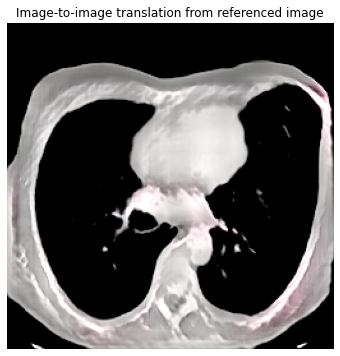

In [39]:
plt.figure(figsize=(9, 6))
plt.imshow(generated_image.cpu().squeeze(dim=0).permute(1, 2, 0))
plt.title('Image-to-image translation from referenced image')
plt.axis(False);

In [34]:
with torch.inference_mode():
    style_encoder.eval()
    generator.eval()
    recon_style_code = style_encoder(x)
    recon_generated_image = generator(generated_image, recon_style_code)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


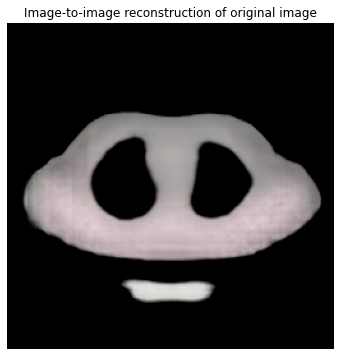

In [35]:
plt.figure(figsize=(9, 6))
plt.imshow(recon_generated_image.cpu().squeeze(dim=0).permute(1, 2, 0))
plt.title('Image-to-image reconstruction of original image')
plt.axis(False);